#### RNN
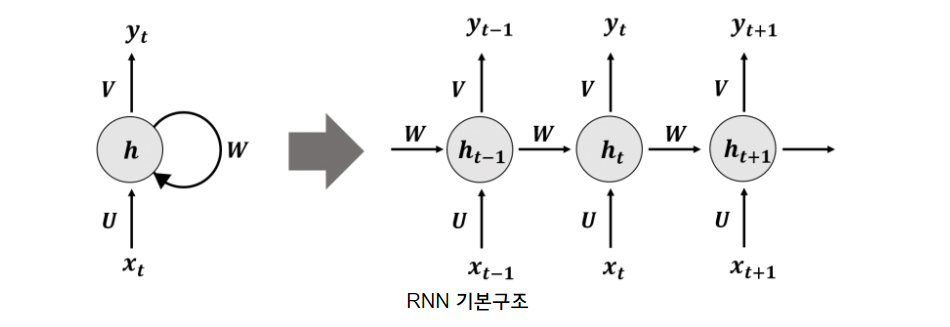
- 출처:http://www.goldenplanet.co.kr/blog/2021/04/27/%EB%B9%85%EB%8D%B0%EC%9D%B4%ED%84%B0-%EA%B3%B5%EB%B6%80-%ED%95%9C-%EA%B1%B8%EC%9D%8C-rnn%EC%88%9C%ED%99%98-%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%B4%EB%9E%80/

#### 토크나이징와 워드임베딩
- 토큰: 워드는 '언어의 최소 단위'인 토큰으로 나눠진다.
- 워드 임베딩: 언어의 최소 단위인 토큰을 벡터 형태로 변환하는 작업

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy import data, datasets

In [2]:
# 하이퍼파라미터 정의
BATCH_SIZE=64
lr=0.001
EPOCHS=40
USE_CUDA=torch.cuda.is_available()
DEVICE=torch.device('cuda' if USE_CUDA else 'cpu')

In [3]:
TEXT=data.Field(sequential=True,batch_first=True,lower=True)# lower=True로 지정하여 텍스트 데이터 속 모든 영문 알파벳이 소문자가 되도록 지정
LABEL=data.Field(sequential=False,batch_first=True)

In [4]:
trainset,testset=datasets.IMDB.splits(TEXT,LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:05<00:00, 14.2MB/s]


In [5]:
TEXT.build_vocab(trainset,min_freq=5)#min_freq: 최소 몇번 등장한 단어만을 사전에 담을 것인지를 지정
LABEL.build_vocab(trainset)

In [6]:
trainset,valset=trainset.split(split_ratio=0.8)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)


In [7]:
vocab_size=len(TEXT.vocab)
n_classes=2

In [8]:
print(f"[학습셋]: {len(trainset)} [검증셋]: {len(valset)} [테스트셋]: {len(testset)} [단어수]: {vocab_size} [클래스]: {n_classes}")

[학습셋]: 20000 [검증셋]: 5000 [테스트셋]: 25000 [단어수]: 46159 [클래스]: 2


#### RNN 구현

- nn.RNN대신 nn.GRU를 사용하는 이유: RNN은 입력이 길어지면 학습 도중 기울기가 너무 작아지거나 커져서 앞부분에 대한 정보를 정확히 담기 불가능하기 때문
- 기울기 폭발(explosion gradient): RNN학습 도중 기울기가 폭발적으로 커지는 현상
- 기울기 소실(vanishing gradient):기울기가 너무 작아지는 현상
- 이것을 보완하기 위해 나온것이 GRU, GRU는 시계열 데이터 속 벡터 사이의 정보 전달량을 조절함으로써 기울기를 적정하게 유지하고 문장 앞부분의 정보가 끝까지 도달할 수 있도록 도와줌 


In [9]:
#RNN 구현
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        print("Building Basic GRU model...")
        self.n_layers = n_layers
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0))
        x, _ = self.gru(x, h_0)  # [i, b, h]
        h_t = x[:,-1,:] # 배치 내 모든 시계열 은닉 벡터들의 마지막 토큰들을 내포한 (batch_size,1,hidden_dim)모양의 텐서를 추출 가능
        self.dropout(h_t)
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_() # 모양을 갖춘 텐서로 변환한 후 zero_()함수 호출해서 텐서 내 모든 값을 0으로 초기화

In [10]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()
    

In [11]:
# 모델 평가를 위해 loss값과 정확도의 평균을 반환
def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [12]:
model = BasicGRU(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building Basic GRU model...


In [13]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss


[이폭: 1] 검증 오차: 0.70 | 검증 정확도:47.92
[이폭: 2] 검증 오차: 0.69 | 검증 정확도:52.18
[이폭: 3] 검증 오차: 0.54 | 검증 정확도:74.98
[이폭: 4] 검증 오차: 0.36 | 검증 정확도:84.98
[이폭: 5] 검증 오차: 0.32 | 검증 정확도:86.54
[이폭: 6] 검증 오차: 0.34 | 검증 정확도:86.08
[이폭: 7] 검증 오차: 0.36 | 검증 정확도:86.94
[이폭: 8] 검증 오차: 0.37 | 검증 정확도:87.14
[이폭: 9] 검증 오차: 0.41 | 검증 정확도:86.82
[이폭: 10] 검증 오차: 0.42 | 검증 정확도:85.98
[이폭: 11] 검증 오차: 0.41 | 검증 정확도:86.22
[이폭: 12] 검증 오차: 0.44 | 검증 정확도:86.22
[이폭: 13] 검증 오차: 0.45 | 검증 정확도:86.34
[이폭: 14] 검증 오차: 0.52 | 검증 정확도:85.30
[이폭: 15] 검증 오차: 0.47 | 검증 정확도:85.86
[이폭: 16] 검증 오차: 0.52 | 검증 정확도:86.18
[이폭: 17] 검증 오차: 0.53 | 검증 정확도:86.38
[이폭: 18] 검증 오차: 0.56 | 검증 정확도:86.02
[이폭: 19] 검증 오차: 0.58 | 검증 정확도:85.80
[이폭: 20] 검증 오차: 0.62 | 검증 정확도:86.32
[이폭: 21] 검증 오차: 0.65 | 검증 정확도:86.44
[이폭: 22] 검증 오차: 0.67 | 검증 정확도:86.38
[이폭: 23] 검증 오차: 0.70 | 검증 정확도:86.32
[이폭: 24] 검증 오차: 0.72 | 검증 정확도:86.44
[이폭: 25] 검증 오차: 0.74 | 검증 정확도:86.34
[이폭: 26] 검증 오차: 0.77 | 검증 정확도:86.30
[이폭: 27] 검증 오차: 0.49 | 검증 정확도:85.96
[이폭: 28] 검증 오차: 0.53 | 검증 정확도:86.34
[

In [14]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss,test_acc=evaluate(model,test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' %(test_loss,test_acc))

테스트 오차:  0.32 | 테스트 정확도: 86.90
